In [ ]:
# | hide
# | default_exp functional
import nbdev
from nbdev.showdoc import *

nbdev.nbdev_export()

# 🔸 Functional operations


In [ ]:
# | exporti

import os

# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"

# MKL_NUM_THREADS=1
# NUMEXPR_NUM_THREADS=1
# OMP_NUM_THREADS=1

import numpy as np
from tidygrad.tensor import Tensor, UnaryElementwiseOp, BinaryElementwiseOp, BaseOp, ExpLog

In [ ]:
# | exporti
class Sigmoid(UnaryElementwiseOp):
    """Take the sigmoid of a tensor"""
    name_template = "sigmoid({})"

    def __init__(self, a, name=None):
        super().__init__(a, name=name)
        # self.out = Tensor(1 / (1 + np.exp(-self.args[0].data)), name=self.name, op=self)
        self.set_out(1 / (1 + np.exp(-self.args[0].data)))


    def backward(self):
        self.check_backward()
        with np.errstate(under="ignore"):  # Triggered by infinitesimally small 1-data
            self.parents[0].grad += self.out.grad * self.out.data * (1 - self.out.data)

In [ ]:
# | export
def sigmoid(input, name=None):
    return Sigmoid(input, name=name).out

In [ ]:
#| export
def softmax(input, name=None):
    exp = input.exp()
    return exp.div(exp.sum(axis=-1, keepdims=True), name=name)

In [ ]:
# | exporti
class Relu(UnaryElementwiseOp):
    """Take the sigmoid of a tensor"""

    name_template = "relu({})"

    def __init__(self, a, name=None):
        super().__init__(a, name=name)
        # self.out = Tensor(np.maximum(0, self.args[0].data), name=self.name, op=self)
        self.set_out(np.maximum(0, self.args[0].data))

    def backward(self):
        self.check_backward()
        self.parents[0].grad += self.out.grad * (self.out.data > 0)

In [ ]:
# | export
def relu(input, name=None):
    return Relu(input, name=name).out

In [ ]:
# | export
def BCE_loss(logits: Tensor, target: Tensor, reduction="mean"):
    loss = logits - logits*target + ExpLog(-logits).out
    if reduction == "mean": return loss.mean()
    if reduction == "sum": return loss.sum()
    assert 0, "Invalid reduction"

In [ ]:
#| export

def CrossEntropy_loss(logits: Tensor, target: Tensor, reduction="mean"):
    if not isinstance(target, Tensor): target = Tensor(target)
    sm = softmax(logits)
    loss = -target * sm.log()
    if reduction == "mean": return loss.mean()
    if reduction == "sum": return loss.sum()
    assert 0, "Invalid reduction"

In [ ]:
# | exporti
class Dropout(UnaryElementwiseOp):
    """Apply Dropout to a tensor"""

    name_template = "dropout({})"

    def __init__(self, a, p_drop=0.1, training=True, name=None):
        super().__init__(a, name=name)
        assert 0 < p_drop < 1, f"p_drop must in (0, 1), got {p_drop}"
        self.p_drop = p_drop
        self.training = training
        if training:
            # Note: We scale up the outputs during training rather than scaling down during inference.
            scale_factor = 1 / (1-p_drop)
            self.mask = np.random.binomial(scale_factor, 1 - p_drop, size=self.args[0].data.shape)
            # self.out = Tensor(self.args[0].data * self.mask, name=self.name, op=self)
            self.set_out(self.args[0].data * self.mask)
        else:
            # self.out = Tensor(self.args[0].data, name=self.name, op=self)
            self.set_out(self.args[0].data)

    def backward(self):
        self.check_backward()
        self.parents[0].grad += self.out.grad * (self.mask if self.training else 1)

In [ ]:
#| exporti
class Embedding(UnaryElementwiseOp):
    """Embedding layer"""

    name_template = "embedding({})"

    def __init__(self, a, indices, name=None):
        super().__init__(a, name=name)
        self.indices = indices
        # self.out = Tensor(self.args[0].data[self.indices], name=self.name, op=self)
        self.set_out(self.args[0].data[self.indices])

    def backward(self):
        self.check_backward()
        self.parents[0].grad[self.indices] += self.out.grad

In [ ]:
#| exporti
def embedding(input, indices, name=None):
    return Embedding(input, indices, name=name).out

In [ ]:
# | export
def dropout(x, p=0.5, training=True):
    if p == 0:
        return x

    return Dropout(x, p_drop=p, training=training).out

### 🔹 Convolution


In [ ]:
#| export

from typing import Union, Tuple

In [ ]:
def np_pad2d(a: np.ndarray, pad: tuple[int, int]) -> np.ndarray:
    h, w = pad
    pad_widths = [(0, 0)] * (a.ndim - 2) + [(h, h), (w, w)]
    return np.pad(a, pad_widths, mode="constant")

def np_unpad2d(a: np.ndarray, pad: tuple[int, int]) -> np.ndarray:
    h, w = pad
    return a[..., h:-h, w:-w]

In [ ]:
# Updated test for np_pad
A = np.array([[1, 2], [3, 4]])
pad_A = np_pad2d(A, (1, 1))
assert np.array_equal(pad_A, [[0, 0, 0, 0], [0, 1, 2, 0], [0, 3, 4, 0], [0, 0, 0, 0]])
A_recovered = np_unpad2d(pad_A, (1, 1))
assert np.array_equal(A, A_recovered)


In [ ]:
#| export
class Pad(UnaryElementwiseOp):
    """Pad a tensor"""
    name_template = "pad2d({})"

    def __init__(self, a, padding: Union[int, Tuple[int, int]], name=None):
        super().__init__(a, name=name)
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.out = Tensor(np_pad2d(a.data, self.padding), name=self.name, op=self)

    def backward(self):
        self.parents[0].grad += np_unpad2d(self.out.grad, self.padding)
        # pY, pX = self.padding
        # slices = (slice(None),) * (len(self.args[0].shape) - 2) \
        #     + (slice(pY, -pY),) + (slice(pX, -pX),)
        # self.parents[0].grad += self.out.grad[slices]

In [ ]:
from matplotlib import pyplot as plt

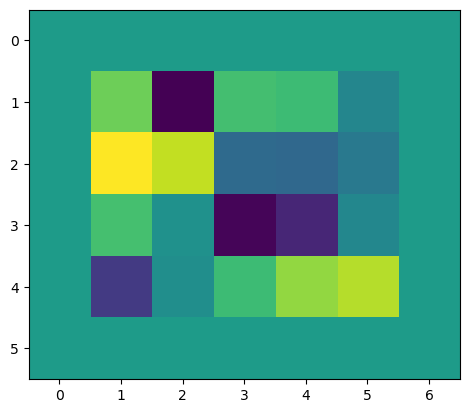

In [ ]:
x = Tensor(np.random.randn(1, 1, 4, 5), name="x")
bias = Pad(x, 1).out

plt.imshow(bias.data[0, 0, :, :]);

In [ ]:
def np_conv2d(input: np.ndarray, kernel: np.ndarray, bias: np.ndarray):
    batch, input_channels, input_height, input_width = input.shape
    output_channels, _input_channels, kernel_height, kernel_width = kernel.shape

    assert kernel_height % 2 == 1, "Only odd kernel sizes are supported for"
    assert kernel_width % 2 == 1, "Only odd kernel sizes are supported for"

    assert input_channels == _input_channels, f"Input channels mismatch: {input_channels} != {_input_channels}"
    assert bias.shape == (output_channels, ), f"Invalid bias shape: {bias.shape}"

    # bias = bias / (kernel_height * kernel_width)

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    y = np.zeros((batch, output_channels, output_height, output_width), dtype=input.dtype)
    for r in range(output_height):
        for c in range(output_width):
            region = input[..., r:r + kernel_height, c:c + kernel_width]
            y[..., r, c] = np.sum(region * kernel, axis=(-1, -2, -3)) + bias
    return y

def np_kernel_grad(input: np.ndarray, kernel: np.ndarray, bias: np.ndarray, grad: np.ndarray):
    batch, input_channels, input_height, input_width = input.shape
    output_channels, _input_channels, kernel_height, kernel_width = kernel.shape

    assert kernel_height % 2 == 1, "Only odd kernel sizes are supported for"
    assert kernel_width % 2 == 1, "Only odd kernel sizes are supported for"

    assert input_channels == _input_channels, f"Input channels mismatch: {input_channels} != {_input_channels}"
    assert bias.shape == (output_channels, ), f"Invalid bias shape: {bias.shape}"

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    # padded_input  # [ batch, input_channels, input_height, input_width
    # kernel        # [ output_channels, input_channels, kernel_height, kernel_width ]
    # grad          # [ batch, output_channels, output_height, output_width ]

    # assert kernel_width == kernel_height, "Only square kernels are supported for now"

    assert grad.shape[-2:] == (output_height, output_width), f"Invalid grad shape: {grad.shape}"

    grad_w = np.zeros_like(kernel)
    for r in range(output_height):
        for c in range(output_width):
            p = input[:, :, r:r + kernel_height, c:c + kernel_width]

            for ch in range(0, output_channels):
                q = grad[:, ch, r, c]
                grad_w[ch, :, :, :] += (p * q).sum(axis=0)

    return grad_w

### Relationship Between Padding, Kernel Size, and Deconvolution

For a convolution operation, given:

- Input size $N$
- Kernel size $k$ (where $k \leq N$)
- Padding $p$ (applied symmetrically on all sides)

The padded input will have a size of $N + 2p$.

After applying the convolution with the kernel, the output $y$ will have a size:

$$
N_y = N + 2p - k + 1
$$

#### Back to Input Domain (Deconvolution)

Before convolving back to the input domain, we apply a new padding $p'$ (unknown at this point) to $N_y$, resulting in a length of $N_y + 2p'$.

After the deconvolution, we get:

$$
(N_y + 2p') - k + 1 = N + 2p - k + 1 + 2p' - k + 1
$$

Simplifying, we find:

$$
N + 2(p + p') - 2k + 2 = N \\
2(p + p') - 2k + 2 = 0 \\
p + p' = k - 1 \\
p' = k - p - 1 \\
$$

This equation gives us the value of $p'$ required to get back to the input domain size $N$ after deconvolution.

---


### Back-propagation through a convolutional layer

For a convolution operation, given:

(even kernels only, stride size one)

- Input size $N$
- Kernel size $k$ (where $k \leq N$)

##### Forward pass:

- Output size will be $N - (k+1)$

For example:
Input 7x7, kernel 3 -> output 5x5
Input 11x11, kernel 5 -> output 7x7

#### Back pass, calculating the gradient for the input.

The shape of the chain gradient will be the same the output.

We are going to apply a convolution to it with the rotated and transposed kernel,
so we need to pad the gradient for the convolution to produce an output of input size.

for example
(Forward ) Input 7x7, kernel 3 -> output 5x5
(Backward) Gradient 5x5, padded by P, kernel 3 -> output should be 7x7

Thus 2P (padding on both sides) should be input_size - output_size + (kernel_size - 1)

And P should be (input_size - output_size + (kernel_size - 1)) / 2  
Note that (kernel_size - 1) is always even, and input_size and output_size
are either both even or both odd, so this divides evenly.


In [ ]:
class Conv2D(BaseOp):
    def __init__(self, input, kernel, bias, stride=1, padding=0, name=None):
        super().__init__(input, kernel, bias, name=name)
        assert stride == 1, "Only stride=1 is supported for now"
        if 1 in kernel.data.shape[-2:]:
            assert padding == 0, "Padding is not supported for 1x1 kernels"
        self.stride = stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.parents = [*self.args] if self.requires_grad else []
        self.input_data_padded = np_pad2d(self.args[0].data, self.padding)

        data = np_conv2d(self.input_data_padded, kernel.data, bias.data)

        self.set_out(data)
        # self.out = Tensor(data, name=self.name, op=self)

    def backward(self):
        rot180 = lambda x: np.rot90(x, 2, axes=(-1, -2)).transpose(1, 0, 2, 3)
        input, kernel, bias = self.args
        grad = self.out.grad

        pad_h = (input.data.shape[-2] - self.out.data.shape[-2] + (kernel.data.shape[-2] - 1))
        pad_w = (input.data.shape[-1] - self.out.data.shape[-1] + (kernel.data.shape[-1] - 1))

        assert pad_h % 2 == 0, "Invalid padding"
        assert pad_w % 2 == 0, "Invalid padding"
        pad_h //= 2
        pad_w //= 2

        padded_grad = np_pad2d(grad, (pad_h, pad_w))
        input.accum_grad(np_conv2d(padded_grad, rot180(kernel.data), np.zeros(input.shape[1])))

        kernel.accum_grad(np_kernel_grad(self.input_data_padded, kernel.data, bias.data, grad))
        bias.accum_grad( grad.sum(axis=(0, -1, -2)))


In [ ]:
from tidygrad.utils.grad_check import grad_check

In [ ]:
h = 12
w = 12
kernel_h = 3
kernel_w = 3

in_ch = 2
out_ch = 5
pad = 1

x = Tensor(np.random.randn(in_ch, h, w)[None], "x", requires_grad=True)

filter = np.random.randn(out_ch, in_ch, kernel_h, kernel_w)
kernel = Tensor(filter, "w", requires_grad=True)

bias = Tensor(np.random.randn(out_ch), "b", requires_grad=True)
conv = Conv2D(x, kernel, bias, padding=pad).out
loss = conv.mean()
loss.backward()

def func(inputs, params):
    x, kernel, bias = params
    return Conv2D(x, kernel, bias, padding=pad).out.mean()

grad_check(func, None, (x, kernel, bias))

Max fractional gradient difference for b: 0.0000%
Max fractional gradient difference for w: 0.0000%


Max fractional gradient difference for x: 0.0000%


In [ ]:
from tidygrad.utils.datasets import MNIST

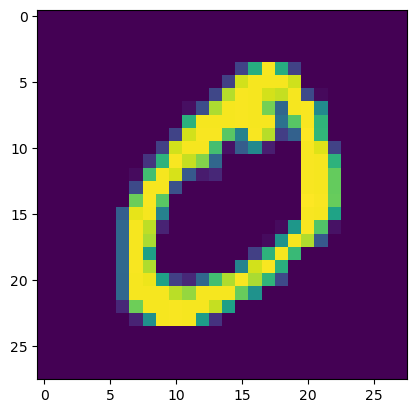

<matplotlib.image.AxesImage>

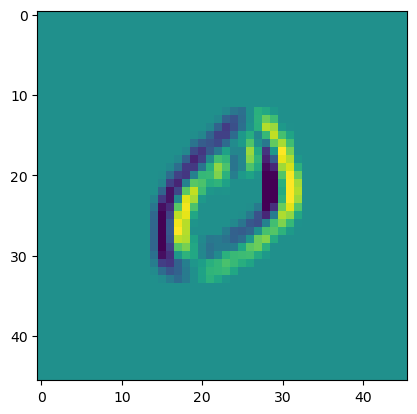

In [ ]:
mnist = MNIST()

x = Tensor(mnist[1][0][None][None], "x")
plt.show(plt.imshow(x.data[0, 0]))

filter = np.array([[1., 0, -1], [1, 0, -1], [1, 0, -1]])[None, None]

kernel = Tensor(filter.reshape(1, 1, 3, 3), "w")
bias = Tensor(np.zeros((1, )), "b")

conv = Conv2D(x, kernel, bias, padding=10).out
# conv = Conv2D(conv, kernel, bias, padding=1).out
# conv = Conv2D(conv, kernel, bias, padding=1).out
plt.imshow(conv.data[0, 0, :, :])

In [ ]:
class MaxPool2D(UnaryElementwiseOp):
    def __init__(self, a, kernel_size, name=None):
        super().__init__(a, name=name)
        self.kernel_size = kernel_size


In [ ]:
A = np.arange(0, 36).reshape(1, 1, 6, 6)
A.reshape(1, 1, 3, 3, 2, 2)

print(A)

block_size = 2

shape = A.shape
new_shape = shape[:-2] + (shape[-2] // block_size, block_size, shape[-1] // block_size, block_size)
A.reshape(new_shape).swapaxes(-2, -3)

def factorial(a):
    return np.prod(np.arange)


[[[[ 0  1  2  3  4  5]
   [ 6  7  8  9 10 11]
   [12 13 14 15 16 17]
   [18 19 20 21 22 23]
   [24 25 26 27 28 29]
   [30 31 32 33 34 35]]]]


In [ ]:
A = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])

A = A.reshape(2, 2, 2, 2)
print(A)
A.swapaxes(-2, -3)

[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]]


 [[[ 9 10]
   [11 12]]

  [[13 14]
   [15 16]]]]


array([[[[ 1,  2],
         [ 5,  6]],

        [[ 3,  4],
         [ 7,  8]]],


       [[[ 9, 10],
         [13, 14]],

        [[11, 12],
         [15, 16]]]])